In [2]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as pltl

import sys
sys.path.append("/usr/local/lib/python2.7/site-packages")
#sys.path.append("/usr/local/lib/python3.5/site-packages")
import RNA

from scipy.stats import pearsonr

In [3]:
pd.options.display.max_colwidth = 200

In [3]:
data = pd.read_csv('apa_general_cuts_antimisprime.csv',sep=',')

print(len(data))
print(data.head())

3411338
                                                                                                                                                                                          seq  \
0  CTGCTTGTTAAGAACAAGTTTGGCTAAGCTGGCTAAAGTGGTAGGCTAAAATATAAAACTATTTGGGAAGTATGAAACGATGTCTCGTGATCTGGTGTACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGGA   
1  CTGCTTGTTAAGAACAAGTTTGGCTATGCTTTCGACGCTGTGGAGCTAAAATATAAAACTATTTGGGAAGTATGAAACGATGTCTCGTGATCTGGTGTACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGGA   
2  CTGCTAGCTGCTCACTGAATGCAGCCTGGTAACTGACCTTCAAAGCTAAAATATAAAACTATTTGGGAAGTATGAAACCCTACTAATATCTTTCTCCGACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGGA   
3  CTGCTTGTTAAGAACAAGTTTGGCTGGTGACGCATTCGTCGACCTCTAAAATATAAAACTATTTGGGAAGTATGAAACTTACATCACCGCTCGTTGGCACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGGA   
4  CTGCTTGTTAAGAACAAGTTTGGC

In [5]:

cut_distribution = spio.loadmat('apa_general_cuts_antimisprime_orig_cutdistribution.mat')['cuts']
cut_distribution = sp.csr_matrix(cut_distribution)

print(cut_distribution.shape)

(3411338, 186)


In [5]:
#Map sequences to RNA
print('Mapping sequences to RNA...')

def map_dna_to_rna(seq) :
    rna = ''
    for b in seq :
        if b == 'A' :
            rna += 'A'
        elif b == 'C' :
            rna += 'C'
        elif b == 'G' :
            rna += 'G'
        elif b == 'T' :
            rna += 'U'
        else :
            rna += ' '
    return rna

data['rna'] = data['seq'].apply(lambda x: map_dna_to_rna(x))

print('Done.')

Mapping sequences to RNA...
Done.


In [6]:
#Fold sequences
print('Folding sequences...')

mfes = np.zeros(len(data))
structures = []
#foldprobs = []

mfes_ext = np.zeros(len(data))
structures_ext = []
#foldprobs_ext = []

mfes_var = np.zeros(len(data))
structures_var = []
#foldprobs_var = []

avg_cuts = []
std_cuts = []

prox_ratios = []

n_processed = 0

for index, row in data.iterrows() :
    if index % 50000 == 0:
        print("Folded up to sequence: " + str(index))
        print("n_processed = " + str(n_processed))
    
    if row['library'] != 22 :
        avg_cuts.append(0)
        std_cuts.append(0)
        
        mfes[index] = -10000
        structures.append('')
        mfes_ext[index] = -10000
        structures_ext.append('')
        mfes_var[index] = -10000
        structures_var.append('')
        prox_ratios.append(0)
        
        continue

    seq = row['rna']
    
    dse = seq[55:100]
    dse_ext = seq[49-10:100]
    
    cuts = np.ravel(cut_distribution[index, :].todense())
    
    if np.sum(cuts[60:100]) <= 0 :
        avg_cuts.append(0)
        std_cuts.append(0)
        
        mfes[index] = -10000
        structures.append('')
        mfes_ext[index] = -10000
        structures_ext.append('')
        mfes_var[index] = -10000
        structures_var.append('')
        prox_ratios.append(0)
        
        continue
    
    n_processed += 1
    
    cuts_dse = cuts[60:100] / np.sum(cuts[60:100])
    
    avg_cut_pos = np.dot((np.arange(40) + 60), cuts_dse)
    std_cut_pos = np.sqrt(np.dot(cuts_dse, np.power(np.arange(len(cuts_dse)) + 60 - avg_cut_pos, 2)))
    
    avg_cuts.append(avg_cut_pos)
    std_cuts.append(np.sqrt(std_cut_pos))
    
    prox_ratio = np.sum(cuts[60:100]) / np.sum(cuts)
    prox_ratios.append(prox_ratio)
    
    
    dse_var = seq[55: int(avg_cut_pos)]

    (structure, mfe) = RNA.fold(dse)
    #(partfunc, efe) = RNA.pf_fold(dse)
    
    (structure_ext, mfe_ext) = RNA.fold(dse_ext)
    #(partfunc_ext, efe_ext) = RNA.pf_fold(dse_ext)
    
    (structure_var, mfe_var) = RNA.fold(dse_var)
    #(partfunc_var, efe_var) = RNA.pf_fold(dse_var)
    

    mfes[index] = mfe
    structures.append(structure)
    #foldprobs.append(partfunc)
    
    mfes_ext[index] = mfe_ext
    structures_ext.append(structure_ext)
    #foldprobs_ext.append(partfunc_ext)
    
    mfes_var[index] = mfe_var
    structures_var.append(structure_var)
    #foldprobs_var.append(partfunc_var)

print('Done.')


Folding sequences...
Folded up to sequence: 0
n_processed = 0
Folded up to sequence: 50000
n_processed = 0
Folded up to sequence: 100000
n_processed = 0
Folded up to sequence: 150000
n_processed = 0
Folded up to sequence: 200000
n_processed = 0
Folded up to sequence: 250000
n_processed = 0
Folded up to sequence: 300000
n_processed = 0
Folded up to sequence: 350000
n_processed = 0
Folded up to sequence: 400000
n_processed = 0
Folded up to sequence: 450000
n_processed = 0
Folded up to sequence: 500000
n_processed = 0
Folded up to sequence: 550000
n_processed = 0
Folded up to sequence: 600000
n_processed = 0
Folded up to sequence: 650000
n_processed = 0
Folded up to sequence: 700000
n_processed = 0
Folded up to sequence: 750000
n_processed = 0
Folded up to sequence: 800000
n_processed = 0
Folded up to sequence: 850000
n_processed = 0
Folded up to sequence: 900000
n_processed = 0
Folded up to sequence: 950000
n_processed = 0
Folded up to sequence: 1000000
n_processed = 0
Folded up to seque

In [9]:

#Storing dataframe
print('Storing datafame...')

data['structure'] = structures
#data['foldprob'] = foldprobs
data['mfe'] = np.ravel(mfes).tolist()

data['structure_ext'] = structures_ext
#data['foldprob_ext'] = foldprobs_ext
data['mfe_ext'] = np.ravel(mfes_ext).tolist()

data['structure_var'] = structures_var
#data['foldprob_var'] = foldprobs_var
data['mfe_var'] = np.ravel(mfes_var).tolist()

data['prox_avgcut'] = avg_cuts
data['prox_stdcut'] = std_cuts

data = data[['seq', 'seq_ext', 'total_count', 'library', 'library_name', 'prox_avgcut', 'prox_stdcut', 'structure', 'mfe', 'structure_ext', 'mfe_ext', 'structure_var', 'mfe_var']]

print(len(data))
#print(data.head())
#print(data.tail())


data.to_csv('apa_general_cuts_antimisprime_dse_folded.csv', header=True, index=False, sep=',')


Storing datafame...
3411338


In [6]:

data = pd.read_csv('apa_general_cuts_antimisprime_dse_folded.csv',sep=',')

print(len(data))


lib = np.ravel(data.library)
lib_index = (lib == 22)


data = data.ix[lib_index == 1]
cut_distribution = cut_distribution[lib_index == 1, :]

data = data.reset_index(drop=True)

print(len(data))
print(cut_distribution.shape)


3411338
772347
(772347, 186)


In [7]:

data_test = data[data.mfe > -1000]#.reset_index(drop=True)

print(len(data_test))

data_test = data_test[(data_test.total_count > 10) & (data_test.prox_stdcut < 2.0)]#.reset_index(drop=True)

print(len(data_test))

data_test = data_test[(data_test.seq.str.slice(50, 56) == 'AATAAA')]#.reset_index(drop=True)

print(len(data_test))

data_test_index = list(data_test.index.values)

cuts_test = cut_distribution[data_test_index, :]

data_test = data_test.reset_index(drop=True)

print(cuts_test.shape)

731521
264101
107557
(107557, 186)


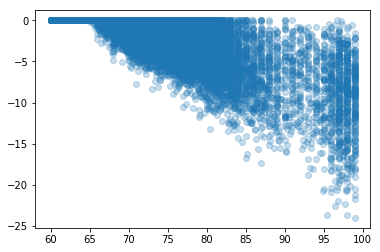

r_val = -0.656927144582
r^2 = 0.431553273288


In [9]:
mfe = np.ravel(data_test.mfe_var).copy()

avg_cut = np.ravel(data_test.prox_avgcut).copy()

f = plt.figure()

plt.scatter(avg_cut, mfe, alpha=0.25)

plt.show()

(r_val, p_val) = pearsonr(avg_cut, mfe)

print('r_val = ' + str(r_val))

print('r^2 = ' + str(r_val * r_val))


In [10]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [128]:

mfe_store = []
seq_store = []
usage_store = []
cutpos_store = []

proxcount_store = []
avgcut_store = []

structurelen_store = []

for test_cut_index in [10, 15, 30, 31, 32, 33, 34, 35] :
    mfe = np.ravel(data_test.mfe_var).copy()
    
    seqs = np.ravel(np.array(data_test.seq, dtype=object)).copy()
    
    avgcut = np.ravel(data_test.prox_avgcut).copy()
    total_count = np.ravel(data_test.total_count).copy()
    
    structure = np.ravel(np.array(data_test.structure_var, dtype=object)).copy()
    structure = structure.tolist()
    structure_len = []
    for j in range(0, len(structure)) :
        structure_len.append(len(structure[j]))
    structure_len = np.ravel(np.array(structure_len))

    prox_cuts = np.array(cuts_test.todense())
    prox_cuts = prox_cuts[:, 60:100]

    prox_norm = np.ravel(np.sum(prox_cuts, axis=1))
    
    prox_count = prox_norm * total_count

    for i in range(0, prox_cuts.shape[0]) :
        prox_cuts[i, :] /= prox_norm[i]
    
    test_cut = np.ravel(np.sum(prox_cuts[:, test_cut_index-1:test_cut_index+1], axis=1))

    invalid_index = (test_cut <= 0.0001) | (test_cut >= 0.9999)
    test_cut = test_cut[invalid_index == 0]
    mfe = mfe[invalid_index == 0]
    seqs = seqs[invalid_index == 0]
    prox_count = prox_count[invalid_index == 0]
    avgcut = avgcut[invalid_index == 0]
    structure_len = structure_len[invalid_index == 0]

    test_cut = np.log(test_cut / (1.0 - test_cut))

    #print(invalid_index.shape)
    print(mfe.shape)
    print(test_cut.shape)
    print(seqs.shape)
    print(prox_count.shape)
    print(avgcut.shape)
    print('')
    
    mfe_store.extend(mfe.tolist())
    seq_store.extend(seqs.tolist())
    usage_store.extend(test_cut.tolist())
    cutpos_store.extend((np.ones(len(test_cut)) * test_cut_index).tolist())
    proxcount_store.extend(prox_count.tolist())
    avgcut_store.extend(avgcut.tolist())
    structurelen_store.extend(structure_len.tolist())


#Storing dataframe
print('Storing datafame...')

data = pd.DataFrame({'seq'  : seq_store,
                    'mfe'  : mfe_store,
                    'observed_logodds'  : usage_store,
                    'cut_pos'  : cutpos_store,
                     'avg_cut'  : avgcut_store,
                     'prox_count'  : proxcount_store,
                     'structure_len'  : structurelen_store
                })

data = data[['seq', 'mfe', 'observed_logodds', 'cut_pos', 'avg_cut', 'prox_count', 'structure_len']]

print(len(data))
print(data.head())

data.to_csv('apa_general_cuts_antimisprime_dse_folded_cuttests.csv', header=True, index=False, sep=',')



(79014,)
(79014,)
(79014,)
(79014,)
(79014,)

(69679,)
(69679,)
(69679,)
(69679,)
(69679,)

(4129,)
(4129,)
(4129,)
(4129,)
(4129,)

(3265,)
(3265,)
(3265,)
(3265,)
(3265,)

(2617,)
(2617,)
(2617,)
(2617,)
(2617,)

(2041,)
(2041,)
(2041,)
(2041,)
(2041,)

(1624,)
(1624,)
(1624,)
(1624,)
(1624,)

(1354,)
(1354,)
(1354,)
(1354,)
(1354,)

Storing datafame...
163723
                                                                                                                                                                                          seq  \
0  GATCTATATCAATAGACATTCAACATCACGAGTGCTCCTAACACTCCCCTAATAAAGTGGGGGGTAGCCTGGTTGTGTATTGGTTAAGCTGGTCACTCGGCATTAAAGGGAGAGGTGGCCCTCGTTTGTCTTCCGTGCGTCTCCAGCGGGTCCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT   
1  GATCTCAAGACGTAAGGAATACTTTTAAATGTAGCCGACGAGTGGTATTAAATAAACATCTATCTAATTTTTTACTCAATCGCTGAGCGTAGGTACGCTGAAATAAATCGTCGACGCGCGGGCGTTTAGAAAGTGGTGCTGCCCGAAGCGGACGCCTAACCCTAAGCAGATTCTTCATGCAATTGT   
2  GATCTAACCGGAGATATGAGGTCCATGATCTTACGTCCTTCTAAGATTTCAAT

In [27]:
data_pred = pd.read_csv('apa_general_cuts_antimisprime_dse_folded_cuttests_pred.csv',sep=',')
print(len(data_pred))
print(data_pred.head())

163723
                                                                                                                                                                                          seq  \
0  GATCTATATCAATAGACATTCAACATCACGAGTGCTCCTAACACTCCCCTAATAAAGTGGGGGGTAGCCTGGTTGTGTATTGGTTAAGCTGGTCACTCGGCATTAAAGGGAGAGGTGGCCCTCGTTTGTCTTCCGTGCGTCTCCAGCGGGTCCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT   
1  GATCTCAAGACGTAAGGAATACTTTTAAATGTAGCCGACGAGTGGTATTAAATAAACATCTATCTAATTTTTTACTCAATCGCTGAGCGTAGGTACGCTGAAATAAATCGTCGACGCGCGGGCGTTTAGAAAGTGGTGCTGCCCGAAGCGGACGCCTAACCCTAAGCAGATTCTTCATGCAATTGT   
2  GATCTAACCGGAGATATGAGGTCCATGATCTTACGTCCTTCTAAGATTTCAATAAAAACTACGTACGCCGCTCGATGAGTTCTCCCACATTTCCCTTAACTAATAAAGGGATGGGCCGGAGGCGTGTCCGATGACACCTGGCGTGAGTTAGTCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT   
3  GATCTTCTGGTTCTTCATGTGCAGTAAAGTTTTCCATCCCTTCCTTCGGGAATAAAGACATTTATAAAATGCTCAGTAATACTCCTTTGTGCTAGCTGGGTATTAAAAACACTGACATTTGTAATAATTTACGTTATCTTTCTGTAAGTTTACGCCTAACCCTAAGCAGATTCTTCATGCAATTGT   
4  GATCTTTTAGCACTAGAAGCGCGAG

(5500,)


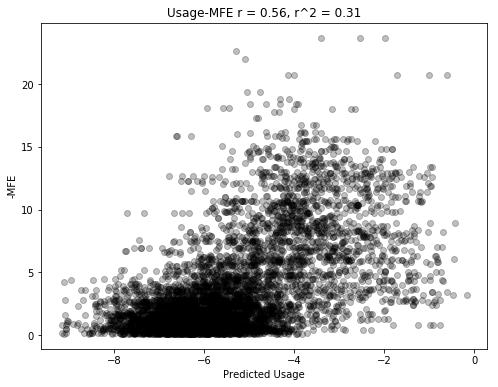

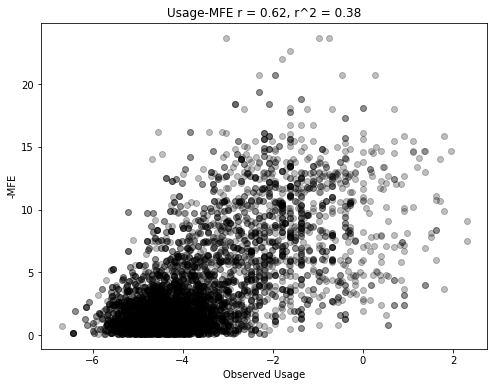

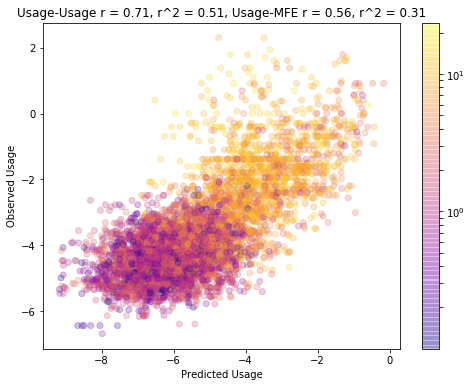

In [154]:
mfe = np.ravel(data_pred.mfe).copy()
cut_pos = np.ravel(data_pred.cut_pos).copy()
usage_true = np.ravel(data_pred.observed_logodds).copy()
usage_pred = np.ravel(data_pred.predicted_logodds).copy()

prox_count = np.ravel(data.prox_count).copy()
avg_cut = np.ravel(data.avg_cut).copy()
structure_len = np.ravel(data.structure_len).copy()

fraction_pred = 1.0 / (1.0 + np.exp(usage_pred))
fraction_true = 1.0 / (1.0 + np.exp(usage_true))

cut_pos_filter = 'geq30'#'le30'#

#valid_index = cut_pos == 31#>= 30
valid_index = (((fraction_pred >= 0.0001) & (fraction_pred <= 0.9999)) & (mfe < 0)) & (cut_pos >= 30)

valid_index = valid_index & (prox_count > 4)
valid_index = valid_index & (avg_cut > 70)
valid_index = valid_index & (structure_len > 15)

#fraction_true_round = np.round(fraction_true, 4)
#valid_index = (((valid_index & (fraction_true_round != 0.5000)) & (fraction_true_round != 0.6667)) & (fraction_true_round != 0.3333))

mfe = mfe[valid_index == 1]
cut_pos = cut_pos[valid_index == 1]
usage_true = usage_true[valid_index == 1]
usage_pred = usage_pred[valid_index == 1]


shuffle_index = np.arange(len(mfe))
np.random.shuffle(shuffle_index)

mfe = mfe[shuffle_index]
cut_pos = cut_pos[shuffle_index]
usage_true = usage_true[shuffle_index]
usage_pred = usage_pred[shuffle_index]

mfe = mfe[:5500]
cut_pos = cut_pos[:5500]
usage_true = usage_true[:5500]
usage_pred = usage_pred[:5500]

print(mfe.shape)

mfe = -1.0 * mfe


(r_val, p_val) = pearsonr(usage_pred, mfe)

f = plt.figure(figsize=(8, 6))

plt.scatter(usage_pred, mfe, alpha=0.25, color='black')
plt.xlabel('Predicted Usage')
plt.ylabel('-MFE')
plt.title('Usage-MFE r = ' + str(round(r_val, 2)) + ', r^2 = ' + str(round(r_val * r_val, 2)))

plt.savefig('mfe_vs_pred_usage_' + cut_pos_filter + '.png')
plt.savefig('mfe_vs_pred_usage_' + cut_pos_filter + '.svg')
plt.show()







(r_val, p_val) = pearsonr(usage_true, mfe)

f = plt.figure(figsize=(8, 6))

plt.scatter(usage_true, mfe, alpha=0.25, color='black')
plt.xlabel('Observed Usage')
plt.ylabel('-MFE')
plt.title('Usage-MFE r = ' + str(round(r_val, 2)) + ', r^2 = ' + str(round(r_val * r_val, 2)))

plt.savefig('mfe_vs_true_usage_' + cut_pos_filter + '.png')
plt.savefig('mfe_vs_true_usage_' + cut_pos_filter + '.svg')
plt.show()



(r_val_mfe, p_val_mfe) = pearsonr(usage_pred, mfe)
(r_val, p_val) = pearsonr(usage_pred, usage_true)

f = plt.figure(figsize=(8, 6))

plt.scatter(usage_pred, usage_true
            , norm=colors.LogNorm(vmin= mfe.min(), vmax= mfe.max())
            , c= mfe, cmap='plasma'#, vmin= -1 * mfe.max(), vmax= -1 * mfe.min()
            , alpha=0.25)

plt.xlabel('Predicted Usage')
plt.ylabel('Observed Usage')
plt.title('Usage-Usage r = ' + str(round(r_val, 2)) + ', r^2 = ' + str(round(r_val * r_val, 2)) + ', Usage-MFE r = ' + str(round(r_val_mfe, 2)) + ', r^2 = ' + str(round(r_val_mfe * r_val_mfe, 2)))

plt.colorbar()

plt.savefig('pred_usage_vs_true_usage_' + cut_pos_filter + '.png')
plt.savefig('pred_usage_vs_true_usage_' + cut_pos_filter + '.svg')
plt.show()


(5500,)


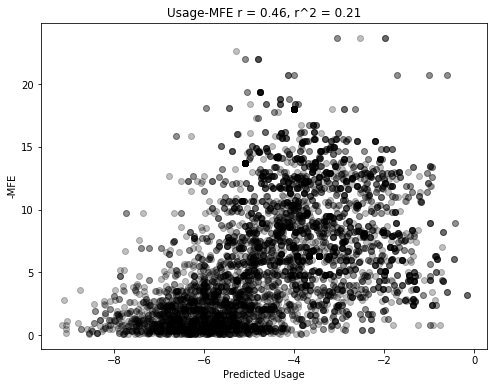

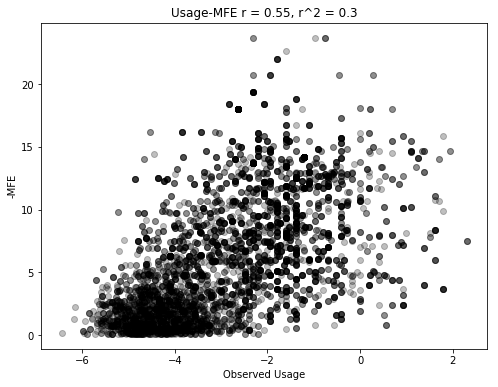

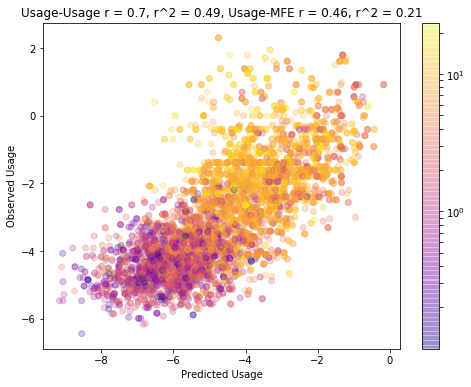

In [151]:
mfe = np.ravel(data_pred.mfe).copy()
cut_pos = np.ravel(data_pred.cut_pos).copy()
usage_true = np.ravel(data_pred.observed_logodds).copy()
usage_pred = np.ravel(data_pred.predicted_logodds).copy()

prox_count = np.ravel(data.prox_count).copy()
avg_cut = np.ravel(data.avg_cut).copy()
structure_len = np.ravel(data.structure_len).copy()

fraction_pred = 1.0 / (1.0 + np.exp(usage_pred))
fraction_true = 1.0 / (1.0 + np.exp(usage_true))

cut_pos_filter = 'geq30'#'le30'#

#valid_index = cut_pos == 31#>= 30
valid_index = (((fraction_pred >= 0.0001) & (fraction_pred <= 0.9999)) & (mfe < 0)) & (cut_pos >= 30)

valid_index = valid_index & (prox_count > 4)
valid_index = valid_index & (avg_cut > 70)
valid_index = valid_index & (structure_len > 15)

#fraction_true_round = np.round(fraction_true, 4)
#valid_index = (((valid_index & (fraction_true_round != 0.5000)) & (fraction_true_round != 0.6667)) & (fraction_true_round != 0.3333))

mfe = mfe[valid_index == 1]
cut_pos = cut_pos[valid_index == 1]
usage_true = usage_true[valid_index == 1]
usage_pred = usage_pred[valid_index == 1]
prox_count = prox_count[valid_index == 1]
avg_cut = avg_cut[valid_index == 1]
structure_len = structure_len[valid_index == 1]


avg_cut_distrib = np.zeros(185)
for i in range(0, len(avg_cut)) :
    avg_cut_distrib[int(avg_cut[i])] += 1

#avg_cut_distrib /= np.sum(avg_cut_distrib)

choice_prob = np.zeros(len(avg_cut))
for i in range(0, len(avg_cut)) :
    choice_prob[i] = (1.0 / float(len(avg_cut_distrib[avg_cut_distrib > 0]))) * (1.0 / avg_cut_distrib[int(avg_cut[i])])

rand_choice_index = np.random.choice(np.arange(len(avg_cut)), 5500, replace=True, p=choice_prob)

mfe = mfe[rand_choice_index]
cut_pos = cut_pos[rand_choice_index]
usage_true = usage_true[rand_choice_index]
usage_pred = usage_pred[rand_choice_index]

print(mfe.shape)

mfe = -1.0 * mfe


(r_val, p_val) = pearsonr(usage_pred, mfe)

f = plt.figure(figsize=(8, 6))

plt.scatter(usage_pred, mfe, alpha=0.25, color='black')
plt.xlabel('Predicted Usage')
plt.ylabel('-MFE')
plt.title('Usage-MFE r = ' + str(round(r_val, 2)) + ', r^2 = ' + str(round(r_val * r_val, 2)))

plt.savefig('mfe_vs_pred_usage_' + cut_pos_filter + '_sampled_replace.png')
plt.savefig('mfe_vs_pred_usage_' + cut_pos_filter + '_sampled_replace.svg')
plt.show()







(r_val, p_val) = pearsonr(usage_true, mfe)

f = plt.figure(figsize=(8, 6))

plt.scatter(usage_true, mfe, alpha=0.25, color='black')
plt.xlabel('Observed Usage')
plt.ylabel('-MFE')
plt.title('Usage-MFE r = ' + str(round(r_val, 2)) + ', r^2 = ' + str(round(r_val * r_val, 2)))

plt.savefig('mfe_vs_true_usage_' + cut_pos_filter + '_sampled_replace.png')
plt.savefig('mfe_vs_true_usage_' + cut_pos_filter + '_sampled_replace.svg')
plt.show()



(r_val_mfe, p_val_mfe) = pearsonr(usage_pred, mfe)
(r_val, p_val) = pearsonr(usage_pred, usage_true)

f = plt.figure(figsize=(8, 6))

plt.scatter(usage_pred, usage_true
            , norm=colors.LogNorm(vmin= mfe.min(), vmax= mfe.max())
            , c= mfe, cmap='plasma'#, vmin= -1 * mfe.max(), vmax= -1 * mfe.min()
            , alpha=0.25)

plt.xlabel('Predicted Usage')
plt.ylabel('Observed Usage')
plt.title('Usage-Usage r = ' + str(round(r_val, 2)) + ', r^2 = ' + str(round(r_val * r_val, 2)) + ', Usage-MFE r = ' + str(round(r_val_mfe, 2)) + ', r^2 = ' + str(round(r_val_mfe * r_val_mfe, 2)))

plt.colorbar()

plt.savefig('pred_usage_vs_true_usage_' + cut_pos_filter + '_sampled_replace.png')
plt.savefig('pred_usage_vs_true_usage_' + cut_pos_filter + '_sampled_replace.svg')
plt.show()
